In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [34]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_reg_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_reg_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'reg_bias')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'unreg_bias')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly', regex=True)
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf', regex=True)
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'r2', 'n_iter']] = cv_results[[
        'param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_r2', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [35]:
from sklearn.datasets import make_regression
from optiml.ml.utils import generate_nonlinearly_regression_data

lin_X, lin_y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)
nonlin_X, nonlin_y = generate_nonlinearly_regression_data(random_state=123456)

## Epsilon-insensitive loss

### Primal formulation

In [47]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [48]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def primal_r2_scorer(svr, X, y):
    if hasattr(svr, 'train_loss_history'):
        
        from optiml.ml.svm import DualSVR
        from optiml.ml.svm.kernels import LinearKernel
        
        dual_svr = DualSVR(loss=epsilon_insensitive, 
                           kernel=LinearKernel(), 
                           C=svr.C, 
                           reg_intercept=True, 
                           optimizer='cvxopt').fit(lin_X, lin_y)
        f_star = np.full_like(svr.train_loss_history, svr.loss(np.append(dual_svr.coef_, dual_svr.intercept_)))
        # (f_t - f^*) / f^*
        train_loss_history[svr.momentum_type][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star),
                                                                              np.maximum(abs(f_star), 1))
        
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter, 
            'n_sv': len(svr.support_)}

Fitting 1 folds for each of 9 candidates, totalling 9 fits
     pcost       dcost       gap    pres   dres
 0: -1.0490e+04 -4.5588e+03  7e+04  2e+01  7e-16
 1: -2.6828e+03 -4.3459e+03  5e+03  1e+00  8e-16
 2: -2.2376e+03 -3.1126e+03  1e+03  1e-01  3e-16
 3: -2.2652e+03 -2.3859e+03  1e+02  2e-02  2e-16
 4: -2.3016e+03 -2.3323e+03  4e+01  4e-03  2e-16
 5: -2.3105e+03 -2.3217e+03  1e+01  1e-03  2e-16
 6: -2.3144e+03 -2.3173e+03  3e+00  2e-04  2e-16
 7: -2.3157e+03 -2.3158e+03  2e-01  5e-06  2e-16
 8: -2.3157e+03 -2.3158e+03  4e-02  5e-07  2e-16
 9: -2.3158e+03 -2.3158e+03  6e-04  6e-09  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0490e+04 -4.5588e+03  7e+04  2e+01  7e-16
 1: -2.6828e+03 -4.3459e+03  5e+03  1e+00  8e-16
 2: -2.2376e+03 -3.1126e+03  1e+03  1e-01  3e-16
 3: -2.2652e+03 -2.3859e+03  1e+02  2e-02  2e-16
 4: -2.3016e+03 -2.3323e+03  4e+01  4e-03  2e-16
 5: -2.3105e+03 -2.3217e+03  1e+01  1e-03  2e-16
 6: -2.3144e+03 -2.3173e+03  3e+00  2

     pcost       dcost       gap    pres   dres
 0: -9.5000e+03 -2.8373e+05  3e+05  0e+00  1e-14
 1: -4.7763e+04 -9.4360e+04  5e+04  1e-16  1e-14
 2: -7.0202e+04 -7.7269e+04  7e+03  2e-16  1e-14
 3: -7.4093e+04 -7.5047e+04  1e+03  2e-16  1e-14
 4: -7.4450e+04 -7.4809e+04  4e+02  2e-16  1e-14
 5: -7.4562e+04 -7.4722e+04  2e+02  2e-16  1e-14
 6: -7.4647e+04 -7.4650e+04  3e+00  2e-16  1e-14
 7: -7.4649e+04 -7.4649e+04  3e-02  2e-16  1e-14
Optimal solution found.


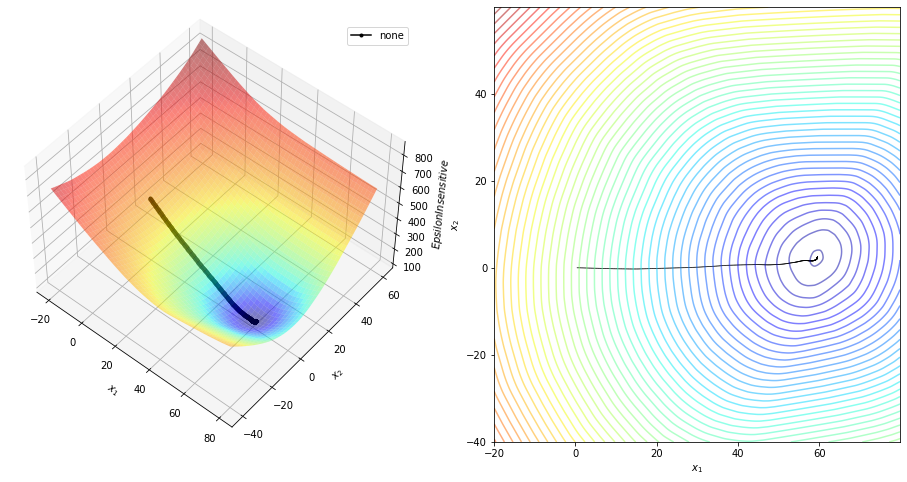

In [49]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
eps_loss_opt = plot_trajectory_optimization(eps_loss, grid.best_estimator_.optimizer, 
                                            color='k', label='none')

In [50]:
none_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
none_primal_svr_eps_cv_results.insert(1, 'momentum', 'none')
none_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      0.340020  0.424402     999    99
                    0.2      0.355860  0.424372     999    99
                    0.3      0.394546  0.424344     999    98
                10  0.1      0.374521  0.977559     999    99
                    0.2      0.339908  0.977554     999    99
                    0.3      0.372087  0.977564     999    99
                100 0.1      0.362631  0.977486     999    98
                    0.2      0.358619  0.977449     999   100
                    0.3      0.344149  0.977460     999    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits
     pcost       dcost       gap    pres   dres
 0: -1.0490e+04 -4.5588e+03  7e+04  2e+01  7e-16
 1: -2.6828e+03 -4.3459e+03  5e+03  1e+00  8e-16
 2: -2.2376e+03 -3.1126e+03  1e+03  1e-01  3e-16
 3: -2.2652e+03 -2.3859e+03  1e+02  2e-02  2e-16
 4: -2.3016e+03 -2.3323e+03  4e+01  4e-03  2e-16
 5: -2.3105e+03 -2.3217e+03  1e+01  1e-03  2e-16
 6: -2.3144e+03 -2.3173e+03  3e+00  2e-04  2e-16
 7: -2.3157e+03 -2.3158e+03  2e-01  5e-06  2e-16
 8: -2.3157e+03 -2.3158e+03  4e-02  5e-07  2e-16
 9: -2.3158e+03 -2.3158e+03  6e-04  6e-09  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0490e+04 -4.5588e+03  7e+04  2e+01  7e-16
 1: -2.6828e+03 -4.3459e+03  5e+03  1e+00  8e-16
 2: -2.2376e+03 -3.1126e+03  1e+03  1e-01  3e-16
 3: -2.2652e+03 -2.3859e+03  1e+02  2e-02  2e-16
 4: -2.3016e+03 -2.3323e+03  4e+01  4e-03  2e-16
 5: -2.3105e+03 -2.3217e+03  1e+01  1e-03  2e-16
 6: -2.3144e+03 -2.3173e+03  3e+00  2

     pcost       dcost       gap    pres   dres
 0: -9.5000e+03 -2.8373e+05  3e+05  0e+00  1e-14
 1: -4.7763e+04 -9.4360e+04  5e+04  1e-16  1e-14
 2: -7.0202e+04 -7.7269e+04  7e+03  2e-16  1e-14
 3: -7.4093e+04 -7.5047e+04  1e+03  2e-16  1e-14
 4: -7.4450e+04 -7.4809e+04  4e+02  2e-16  1e-14
 5: -7.4562e+04 -7.4722e+04  2e+02  2e-16  1e-14
 6: -7.4647e+04 -7.4650e+04  3e+00  2e-16  1e-14
 7: -7.4649e+04 -7.4649e+04  3e-02  2e-16  1e-14
Optimal solution found.


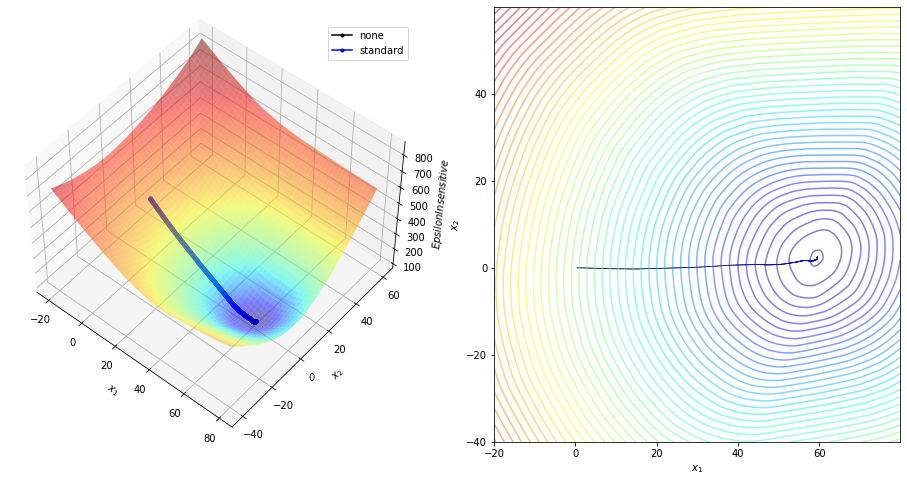

In [51]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='standard', 
                              momentum=0.4, 
                              early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='b', label='standard')
eps_loss_opt

In [52]:
standard_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svr_eps_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
standard_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    standard 1   0.1      0.348277  0.604310     999   100
                    0.2      0.356877  0.604321     999   100
                    0.3      0.378746  0.604346     999   100
                10  0.1      0.376532  0.977559     999    99
                    0.2      0.358045  0.977554     999    99
                    0.3      0.343953  0.977564     999    99
                100 0.1      0.365639  0.977485     999    98
                    0.2      0.383956  0.977455     999    98
                    0.3      0.392200  0.977473     999    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits
     pcost       dcost       gap    pres   dres
 0: -1.0490e+04 -4.5588e+03  7e+04  2e+01  7e-16
 1: -2.6828e+03 -4.3459e+03  5e+03  1e+00  8e-16
 2: -2.2376e+03 -3.1126e+03  1e+03  1e-01  3e-16
 3: -2.2652e+03 -2.3859e+03  1e+02  2e-02  2e-16
 4: -2.3016e+03 -2.3323e+03  4e+01  4e-03  2e-16
 5: -2.3105e+03 -2.3217e+03  1e+01  1e-03  2e-16
 6: -2.3144e+03 -2.3173e+03  3e+00  2e-04  2e-16
 7: -2.3157e+03 -2.3158e+03  2e-01  5e-06  2e-16
 8: -2.3157e+03 -2.3158e+03  4e-02  5e-07  2e-16
 9: -2.3158e+03 -2.3158e+03  6e-04  6e-09  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0490e+04 -4.5588e+03  7e+04  2e+01  7e-16
 1: -2.6828e+03 -4.3459e+03  5e+03  1e+00  8e-16
 2: -2.2376e+03 -3.1126e+03  1e+03  1e-01  3e-16
 3: -2.2652e+03 -2.3859e+03  1e+02  2e-02  2e-16
 4: -2.3016e+03 -2.3323e+03  4e+01  4e-03  2e-16
 5: -2.3105e+03 -2.3217e+03  1e+01  1e-03  2e-16
 6: -2.3144e+03 -2.3173e+03  3e+00  2

     pcost       dcost       gap    pres   dres
 0: -9.5000e+03 -2.8373e+05  3e+05  0e+00  1e-14
 1: -4.7763e+04 -9.4360e+04  5e+04  1e-16  1e-14
 2: -7.0202e+04 -7.7269e+04  7e+03  2e-16  1e-14
 3: -7.4093e+04 -7.5047e+04  1e+03  2e-16  1e-14
 4: -7.4450e+04 -7.4809e+04  4e+02  2e-16  1e-14
 5: -7.4562e+04 -7.4722e+04  2e+02  2e-16  1e-14
 6: -7.4647e+04 -7.4650e+04  3e+00  2e-16  1e-14
 7: -7.4649e+04 -7.4649e+04  3e-02  2e-16  1e-14
Optimal solution found.


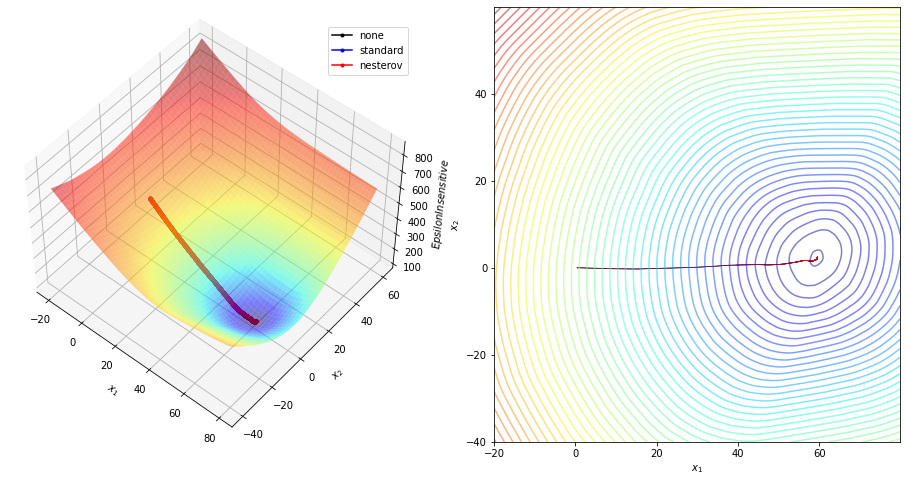

In [53]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='r', label='nesterov')
eps_loss_opt.savefig('./tex/img/l1_svr_loss.png')
eps_loss_opt

In [54]:
nesterov_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svr_eps_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    nesterov 1   0.1      0.326851  0.604256     999   100
                    0.2      0.352876  0.604267     999   100
                    0.3      0.370466  0.604293     999   100
                10  0.1      0.372924  0.977559     999    99
                    0.2      0.368915  0.977554     999    98
                    0.3      0.368247  0.977564     999    99
                100 0.1      0.387535  0.977482     999    99
                    0.2      0.385766  0.977451     999    99
                    0.3      0.396675  0.977476     999    98

In [55]:
custom_primal_svr_eps_cv_results = none_primal_svr_eps_cv_results.append(
    standard_primal_svr_eps_cv_results).append(
    nesterov_primal_svr_eps_cv_results)
custom_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      0.340020  0.424402     999    99
                    0.2      0.355860  0.424372     999    99
                    0.3      0.394546  0.424344     999    98
                10  0.1      0.374521  0.977559     999    99
                    0.2      0.339908  0.977554     999    99
                    0.3      0.372087  0.977564     999    99
                100 0.1      0.362631  0.977486     999    98
                    0.2      0.358619  0.977449     999   100
                    0.3      0.344149  0.977460     999    98
       standard 1   0.1      0.348277  0.604310     999   100
                    0.2      0.356877  0.604321     999   100
                    0.3      0.378746  0.604346     999   100
                10  0.1      0.376532  0.977559     999    99
                    0.2      0.358045  0.977554     999    99
                    0.3      0.343953  0.977564     999    99
                100 0.1      0.365639  0.977485     999    98
                    0.2      0.383956  0.977455     999    98
                    0.3      0.392200  0.977473     999    98
       nesterov 1   0.1      0.326851  0.604256     999   100
                    0.2      0.352876  0.604267     999   100
                    0.3      0.370466  0.604293     999   100
                10  0.1      0.372924  0.977559     999    99
                    0.2      0.368915  0.977554     999    98
                    0.3      0.368247  0.977564     999    99
                100 0.1      0.387535  0.977482     999    99
                    0.2      0.385766  0.977451     999    99
                    0.3      0.396675  0.977476     999    98

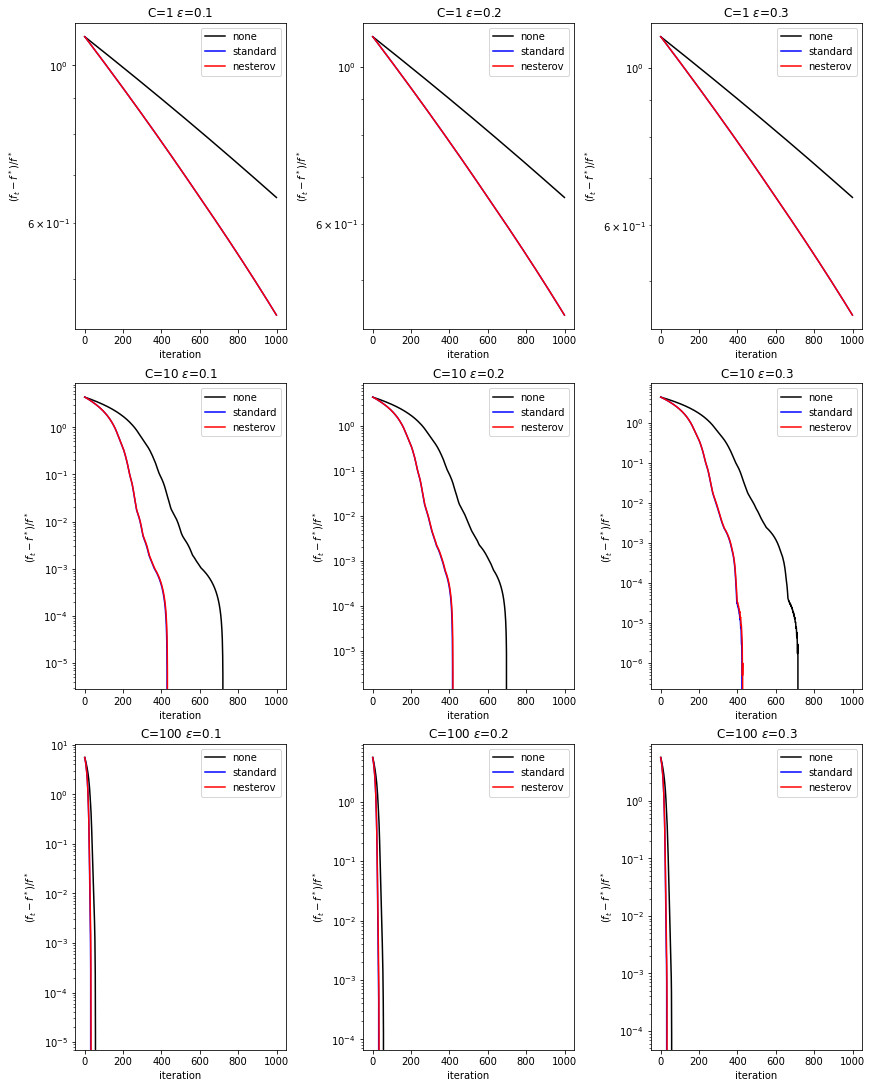

In [56]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for momentum, _dict1 in train_loss_history.items():
    for (C, _dict2), row_ax in zip(_dict1.items(), axes):
        for (eps, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[momentum])
            loss.set_title('C={:d} $\epsilon$={:.1f}'.format(C, eps))
            loss.set_xlabel('iteration')
            loss.set_ylabel('$(f_t - f^*) / f^*$')
            loss.set_yscale('log')
            loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/l1_svr_loss_history.png')

In [57]:
grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive', 
                                random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [17]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.001556  0.964163      12    97
                       0.2      0.001693  0.963786      12    97
                       0.3      0.001319  0.963443      18    95
                   10  0.1      0.001913  0.977559     111   100
                       0.2      0.001257  0.977552     126    99
                       0.3      0.001697  0.977564     253    98
                   100 0.1      0.001806  0.977481     672    99
                       0.2      0.001725  0.977442     881    99
                       0.3      0.005347  0.977458    1000    98

In [18]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_l1_svr.tex', 
                                   caption='Primal $\protect \mathcal{L}_1$-SVR results', 
                                   label='primal_l1_svr_cv_results', position='H')
primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
sgd       none     1   0.1      2.307383  0.119916    1000   100
                       0.2      2.191412  0.119916    1000   100
                       0.3      2.333664  0.119916    1000   100
                   10  0.1      2.013559  0.815212    1000   100
                       0.2      1.173720  0.815222    1000   100
                       0.3      1.462245  0.815215    1000    99
                   100 0.1      0.438632  0.977561     261    99
                       0.2      0.425132  0.977558     271    99
                       0.3      0.476846  0.977558     270    97
          standard 1   0.1      1.251207  0.176352    1000   100
                       0.2      1.165600  0.176352    1000   100
                       0.3      1.187524  0.176352    1000   100
                   10  0.1      1.170662  0.954799    1000    98
                       0.2      1.169940  0.954776    1000    97
                       0.3      1.185189  0.954761    1000    96
                   100 0.1      0.251454  0.977561     158    99
                       0.2      0.257241  0.977558     163    99
                       0.3      0.270931  0.977553     177    97
          nesterov 1   0.1      1.166248  0.176347    1000   100
                       0.2      1.209639  0.176347    1000   100
                       0.3      1.220824  0.176347    1000   100
                   10  0.1      1.187118  0.954791    1000    98
                       0.2      1.191491  0.954768    1000    97
                       0.3      1.192702  0.954752    1000    96
                   100 0.1      0.246223  0.977562     158    99
                       0.2      0.272774  0.977558     164   100
                       0.3      0.262561  0.977553     176    98
liblinear -        1   0.1      0.001556  0.964163      12    97
                       0.2      0.001693  0.963786      12    97
                       0.3      0.001319  0.963443      18    95
                   10  0.1      0.001913  0.977559     111   100
                       0.2      0.001257  0.977552     126    99
                       0.3      0.001697  0.977564     253    98
                   100 0.1      0.001806  0.977481     672    99
                       0.2      0.001725  0.977442     881    99
                       0.3      0.005347  0.977458    1000    98

### Dual formulations

In [88]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.svm.kernels import LinearKernel, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [89]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [90]:
train_loss_history = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

def dual_r2_scorer(svr, X, y):
    if hasattr(svr, 'train_loss_history') and svr.optimizer.iter > 0:
        dual_svr = DualSVR(loss=epsilon_insensitive, 
                           kernel=svr.kernel, 
                           C=svr.C, 
                           reg_intercept=svr.reg_intercept, 
                           optimizer='cvxopt')
        if isinstance(svr.kernel, LinearKernel):
            dual_svr.fit(lin_X, lin_y)
        else:
            dual_svr.fit(nonlin_X, nonlin_y)
        f_star = np.full_like(svr.train_loss_history, dual_svr.obj(dual_svr.alphas_))
        # (t, (f_t - f^*) / f^*)
        dual = 'reg_bias' if svr.reg_intercept else 'unreg_bias'
        train_loss_history[dual][svr.kernel.__class__.__name__][svr.C][svr.epsilon] = (svr.train_time_history, 
                                                                                       np.divide((svr.train_loss_history - f_star), 
                                                                                                 np.maximum(abs(f_star), 1)))
        
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0: -1.0400e+04 -2.9938e+04  7e+04  1e+00  1e-15
 1: -6.7514e+03 -1.6621e+04  1e+04  3e-16  1e-15
 2: -8.3660e+03 -9.5854e+03  1e+03  2e-16  1e-15
 3: -8.9389e+03 -9.1846e+03  2e+02  2e-16  1e-15
 4: -9.0466e+03 -9.0991e+03  5e+01  2e-16  1e-15
 5: -9.0661e+03 -9.0818e+03  2e+01  2e-16  1e-15
 6: -9.0743e+03 -9.0746e+03  3e-01  2e-16  1e-15
 7: -9.0744e+03 -9.0744e+03  3e-03  2e-16  1e-15
Optimal solution found.


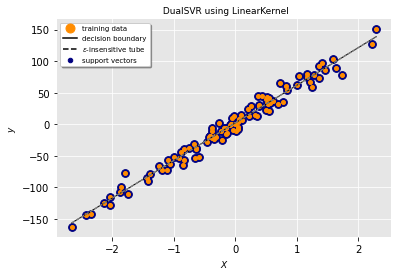

In [71]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, 
                            kernel=LinearKernel()),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_l1_svr_hyperplane.png')

In [72]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
cvxopt 1   0.1      0.044552  0.964068      10   100
           0.2      0.059117  0.964118      10   100
           0.3      0.050135  0.963452      10    99
       10  0.1      0.028776  0.977576       8   100
           0.2      0.041003  0.977573       9   100
           0.3      0.043670  0.977573       9    99
       100 0.1      0.030750  0.977515       8   100
           0.2      0.038060  0.977496       9   100
           0.3      0.031613  0.977493       9   100
smo    1   0.1      0.028140  0.964127      17    98
           0.2      0.030811  0.963707      18    96
           0.3      0.031082  0.963707      14    96
       10  0.1      0.107682  0.977576      65   100
           0.2      0.437226  0.977573     749   100
           0.3      0.127640  0.977573      78    99
       100 0.1      0.422207  0.977515     549   100
           0.2      0.468320  0.977496     723   100
           0.3      0.528651  0.977493     926    99

In [24]:
grid = GridSearchCV(SklSVR(kernel='linear', 
                           verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[LibSVM]

In [25]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
libsvm 1   0.1      0.002630  0.964103      81    98
           0.2      0.003279  0.963680      81    97
           0.3      0.002134  0.963684      78    96
       10  0.1      0.002560  0.977559     226   100
           0.2      0.002932  0.977554     706   100
           0.3      0.002898  0.977564     181    99
       100 0.1      0.003907  0.977481    1224   100
           0.2      0.003300  0.977450    2126   100
           0.3      0.003670  0.977463    2680    99

In [26]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results)
linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], ascending=[False, True, True], inplace=True)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_l1_svr.tex', 
                                    caption='Wolfe Dual linear $\protect \mathcal{L}_1$-SVR results', 
                                    label='linear_dual_l1_svr_cv_results', position='H')
linear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
smo    1   0.1      0.060325  0.964127      17    98
           0.2      0.071465  0.963707      18    96
           0.3      0.068385  0.963707      14    96
       10  0.1      0.183926  0.977576      65   100
           0.2      0.383894  0.977573     749   100
           0.3      0.165514  0.977573      78    99
       100 0.1      0.434502  0.977515     549   100
           0.2      0.461811  0.977496     723   100
           0.3      0.410521  0.977493     926    99
libsvm 1   0.1      0.002630  0.964103      81    98
           0.2      0.003279  0.963680      81    97
           0.3      0.002134  0.963684      78    96
       10  0.1      0.002560  0.977559     226   100
           0.2      0.002932  0.977554     706   100
           0.3      0.002898  0.977564     181    99
       100 0.1      0.003907  0.977481    1224   100
           0.2      0.003300  0.977450    2126   100
           0.3      0.003670  0.977463    2680    99
cvxopt 1   0.1      0.094744  0.964068      10   100
           0.2      0.095626  0.964118      10   100
           0.3      0.105664  0.963452      10    99
       10  0.1      0.131441  0.977576       8   100
           0.2      0.112558  0.977573       9   100
           0.3      0.074020  0.977573       9    99
       100 0.1      0.053100  0.977515       8   100
           0.2      0.035742  0.977496       9   100
           0.3      0.027918  0.977493       9   100

##### Nonlinear

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0:  1.9943e+03 -2.2457e+04  2e+04  0e+00  5e-10
 1:  1.6485e+03 -1.4960e+03  3e+03  1e-16  4e-10
 2:  2.7294e+02 -1.9201e+02  5e+02  2e-16  3e-10
 3:  4.7106e+01 -3.8722e+01  9e+01  2e-16  1e-10
 4:  9.1882e+00 -9.5019e+00  2e+01  2e-16  3e-11
 5:  4.8977e-01 -1.8622e+00  2e+00  2e-16  4e-12
 6:  2.9291e-01 -1.6173e+00  2e+00  2e-16  2e-12
 7: -4.0534e-01 -9.5519e-01  5e-01  2e-16  9e-13
 8: -6.7624e-01 -7.0485e-01  3e-02  2e-16  5e-13
 9: -6.9005e-01 -6.9035e-01  3e-04  2e-16  5e-13
10: -6.9019e-01 -6.9020e-01  3e-06  2e-16  4e-13
11: -6.9019e-01 -6.9019e-01  3e-08  2e-16  5e-13
Optimal solution found.


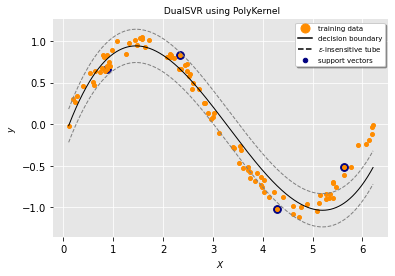

In [27]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_l1_svr_hyperplane.png')

In [28]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results

fit_time        r2   n_iter  n_sv
solver kernel C   epsilon                                      
cvxopt poly   1   0.1         0.038866  0.828482       10    37
                  0.2         0.052302  0.666571       10     6
                  0.3         0.064375  0.350876        9     4
              10  0.1         0.072247  0.629433       10    33
                  0.2         0.066396  0.928477       10     4
                  0.3         0.041655  0.350873       10     4
              100 0.1         0.040034  0.712681       10    36
                  0.2         0.071648  0.928478       10     4
                  0.3         0.058262  0.350876       10     4
smo    poly   1   0.1        32.246417  0.810056    47694    36
                  0.2         6.038541  0.671256     8702     6
                  0.3         2.493421  0.302709     3654     4
              10  0.1       137.386818  0.736098   256531    32
                  0.2        21.928680  0.923152    32629     4
                  0.3         2.612937  0.302709     3654     4
              100 0.1      1162.409664  0.635585  3294613    33
                  0.2        17.946368  0.923152    32629     4
                  0.3         2.386922  0.302709     3654     4

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0:  9.9722e+02 -2.3019e+04  2e+04  0e+00  1e-12
 1:  8.8761e+02 -1.3911e+03  2e+03  1e-16  2e-12
 2:  1.7095e+02 -1.6286e+02  3e+02  1e-16  1e-12
 3:  2.8000e+01 -5.5447e+01  8e+01  2e-16  5e-13
 4:  1.9850e+00 -3.1537e+01  3e+01  2e-16  3e-13
 5: -1.1406e+01 -1.8729e+01  7e+00  2e-16  3e-13
 6: -1.4158e+01 -1.6108e+01  2e+00  2e-16  2e-13
 7: -1.4924e+01 -1.5333e+01  4e-01  2e-16  3e-13
 8: -1.5103e+01 -1.5153e+01  5e-02  2e-16  3e-13
 9: -1.5127e+01 -1.5128e+01  1e-03  2e-16  3e-13
10: -1.5127e+01 -1.5127e+01  1e-05  2e-16  3e-13
Optimal solution found.


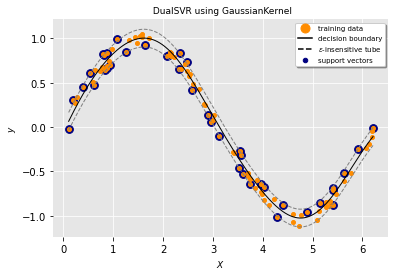

In [29]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_l1_svr_hyperplane.png')

In [30]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver kernel C   epsilon                                  
cvxopt rbf    1   0.1      0.050553  0.988117      10    17
                  0.2      0.042559  0.924679      10     7
                  0.3      0.029519  0.883386      10     5
              10  0.1      0.030551  0.989956      10    18
                  0.2      0.022031  0.925595      10     6
                  0.3      0.037305  0.883386      10     5
              100 0.1      0.031857  0.990216      10    40
                  0.2      0.029449  0.925595      10     6
                  0.3      0.027231  0.883386      10     5
smo    rbf    1   0.1      0.037066  0.988244      66    17
                  0.2      0.016972  0.924292      20     7
                  0.3      0.014495  0.883022      17     5
              10  0.1      0.415330  0.989739     389    18
                  0.2      0.026076  0.924995      25     6
                  0.3      0.010857  0.882816      11     5
              100 0.1      3.581247  0.974756    6664    19
                  0.2      0.024208  0.924995      25     6
                  0.3      0.010397  0.882816      11     5

In [31]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results)
custom_nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_svr_cv_results

fit_time        r2   n_iter  n_sv
solver kernel C   epsilon                                      
cvxopt poly   1   0.1         0.038866  0.828482       10    37
                  0.2         0.052302  0.666571       10     6
                  0.3         0.064375  0.350876        9     4
              10  0.1         0.072247  0.629433       10    33
                  0.2         0.066396  0.928477       10     4
                  0.3         0.041655  0.350873       10     4
              100 0.1         0.040034  0.712681       10    36
                  0.2         0.071648  0.928478       10     4
                  0.3         0.058262  0.350876       10     4
       rbf    1   0.1         0.050553  0.988117       10    17
                  0.2         0.042559  0.924679       10     7
                  0.3         0.029519  0.883386       10     5
              10  0.1         0.030551  0.989956       10    18
                  0.2         0.022031  0.925595       10     6
                  0.3         0.037305  0.883386       10     5
              100 0.1         0.031857  0.990216       10    40
                  0.2         0.029449  0.925595       10     6
                  0.3         0.027231  0.883386       10     5
smo    poly   1   0.1        32.246417  0.810056    47694    36
                  0.2         6.038541  0.671256     8702     6
                  0.3         2.493421  0.302709     3654     4
              10  0.1       137.386818  0.736098   256531    32
                  0.2        21.928680  0.923152    32629     4
                  0.3         2.612937  0.302709     3654     4
              100 0.1      1162.409664  0.635585  3294613    33
                  0.2        17.946368  0.923152    32629     4
                  0.3         2.386922  0.302709     3654     4
       rbf    1   0.1         0.037066  0.988244       66    17
                  0.2         0.016972  0.924292       20     7
                  0.3         0.014495  0.883022       17     5
              10  0.1         0.415330  0.989739      389    18
                  0.2         0.026076  0.924995       25     6
                  0.3         0.010857  0.882816       11     5
              100 0.1         3.581247  0.974756     6664    19
                  0.2         0.024208  0.924995       25     6
                  0.3         0.010397  0.882816       11     5

In [32]:
grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[LibSVM]

In [33]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results

fit_time        r2    n_iter  n_sv
solver kernel C   epsilon                                    
libsvm poly   1   0.1      0.055048  0.981438    155092    37
                  0.2      0.004135  0.976358      7326     6
                  0.3      0.003601  0.951282      3969     4
              10  0.1      0.156975  0.981769    578347    32
                  0.2      0.009017  0.979414     28452     4
                  0.3      0.003885  0.951282      3969     4
              100 0.1      2.562683  0.981844  13306191    35
                  0.2      0.007999  0.979414     28452     4
                  0.3      0.005801  0.951282      3969     4
       rbf    1   0.1      0.004138  0.990088        96    17
                  0.2      0.004025  0.977763        36     7
                  0.3      0.014884  0.945601        24     5
              10  0.1      0.008720  0.990493       616    18
                  0.2      0.001334  0.980673        39     6
                  0.3      0.003223  0.945601        24     5
              100 0.1      0.006933  0.990496      9854    18
                  0.2      0.001670  0.980673        39     6
                  0.3      0.001246  0.945601        24     5

In [34]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results)
nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_l1_svr.tex', 
                                       caption='Wolfe Dual nonlinear $\protect \mathcal{L}_1$-SVR formulation results', 
                                       label='nonlinear_dual_l1_svr_cv_results', position='H')
nonlinear_dual_svr_cv_results

fit_time        r2    n_iter  n_sv
solver kernel C   epsilon                                       
smo    poly   1   0.1        32.246417  0.810056     47694    36
                  0.2         6.038541  0.671256      8702     6
                  0.3         2.493421  0.302709      3654     4
              10  0.1       137.386818  0.736098    256531    32
                  0.2        21.928680  0.923152     32629     4
                  0.3         2.612937  0.302709      3654     4
              100 0.1      1162.409664  0.635585   3294613    33
                  0.2        17.946368  0.923152     32629     4
                  0.3         2.386922  0.302709      3654     4
       rbf    1   0.1         0.037066  0.988244        66    17
                  0.2         0.016972  0.924292        20     7
                  0.3         0.014495  0.883022        17     5
              10  0.1         0.415330  0.989739       389    18
                  0.2         0.026076  0.924995        25     6
                  0.3         0.010857  0.882816        11     5
              100 0.1         3.581247  0.974756      6664    19
                  0.2         0.024208  0.924995        25     6
                  0.3         0.010397  0.882816        11     5
libsvm poly   1   0.1         0.055048  0.981438    155092    37
                  0.2         0.004135  0.976358      7326     6
                  0.3         0.003601  0.951282      3969     4
              10  0.1         0.156975  0.981769    578347    32
                  0.2         0.009017  0.979414     28452     4
                  0.3         0.003885  0.951282      3969     4
              100 0.1         2.562683  0.981844  13306191    35
                  0.2         0.007999  0.979414     28452     4
                  0.3         0.005801  0.951282      3969     4
       rbf    1   0.1         0.004138  0.990088        96    17
                  0.2         0.004025  0.977763        36     7
                  0.3         0.014884  0.945601        24     5
              10  0.1         0.008720  0.990493       616    18
                  0.2         0.001334  0.980673        39     6
                  0.3         0.003223  0.945601        24     5
              100 0.1         0.006933  0.990496      9854    18
                  0.2         0.001670  0.980673        39     6
                  0.3         0.001246  0.945601        24     5
cvxopt poly   1   0.1         0.038866  0.828482        10    37
                  0.2         0.052302  0.666571        10     6
                  0.3         0.064375  0.350876         9     4
              10  0.1         0.072247  0.629433        10    33
                  0.2         0.066396  0.928477        10     4
                  0.3         0.041655  0.350873        10     4
              100 0.1         0.040034  0.712681        10    36
                  0.2         0.071648  0.928478        10     4
                  0.3         0.058262  0.350876        10     4
       rbf    1   0.1         0.050553  0.988117        10    17
                  0.2         0.042559  0.924679        10     7
                  0.3         0.029519  0.883386        10     5
              10  0.1         0.030551  0.989956        10    18
                  0.2         0.022031  0.925595        10     6
                  0.3         0.037305  0.883386        10     5
              100 0.1         0.031857  0.990216        10    40
                  0.2         0.029449  0.925595        10     6
                  0.3         0.027231  0.883386        10     5

#### Lagrangian Dual

##### Linear

In [93]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, 
                            kernel=LinearKernel(), 
                            optimizer=AdaGrad, 
                            learning_rate=0.001),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0: -1.0490e+04 -4.5588e+03  7e+04  2e+01  7e-16
 1: -2.6828e+03 -4.3459e+03  5e+03  1e+00  8e-16
 2: -2.2376e+03 -3.1126e+03  1e+03  1e-01  3e-16
 3: -2.2652e+03 -2.3859e+03  1e+02  2e-02  2e-16
 4: -2.3016e+03 -2.3323e+03  4e+01  4e-03  2e-16
 5: -2.3105e+03 -2.3217e+03  1e+01  1e-03  2e-16
 6: -2.3144e+03 -2.3173e+03  3e+00  2e-04  2e-16
 7: -2.3157e+03 -2.3158e+03  2e-01  5e-06  2e-16
 8: -2.3157e+03 -2.3158e+03  4e-02  5e-07  2e-16
 9: -2.3158e+03 -2.3158e+03  6e-04  6e-09  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0490e+04 -4.5588e+03  7e+04  2e+01  7e-16
 1: -2.6828e+03 -4.3459e+03  5e+03  1e+00  8e-16
 2: -2.2376e+03 -3.1126e+03  1e+03  1e-01  3e-16
 3: -2.2652e+03 -2.3859e+03  1e+02  2e-02  2e-16
 4: -2.3016e+03 -2.3323e+03  4e+01  4e-03  2e-16
 5: -2.3105e+03 -2.3217e+03  1e+01  1e-03  2e-16
 6: -2.3144e+03 -2.3173e+03  3e+00 

     pcost       dcost       gap    pres   dres
 0: -1.0397e+04 -2.9962e+04  7e+04  1e+00  7e-16
 1: -6.7462e+03 -1.6638e+04  1e+04  5e-14  5e-16
 2: -8.3626e+03 -9.5795e+03  1e+03  1e-13  4e-16
 3: -8.9398e+03 -9.1780e+03  2e+02  1e-13  4e-16
 4: -9.0354e+03 -9.1031e+03  7e+01  7e-14  3e-16
 5: -9.0662e+03 -9.0757e+03  9e+00  2e-13  4e-16
 6: -9.0712e+03 -9.0713e+03  1e-01  2e-13  5e-16
 7: -9.0712e+03 -9.0712e+03  1e-03  1e-13  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0400e+04 -2.9938e+04  7e+04  1e+00  1e-15
 1: -6.7514e+03 -1.6621e+04  1e+04  3e-16  1e-15
 2: -8.3660e+03 -9.5854e+03  1e+03  2e-16  1e-15
 3: -8.9389e+03 -9.1846e+03  2e+02  2e-16  1e-15
 4: -9.0466e+03 -9.0991e+03  5e+01  2e-16  1e-15
 5: -9.0661e+03 -9.0818e+03  2e+01  2e-16  1e-15
 6: -9.0743e+03 -9.0746e+03  3e-01  2e-16  1e-15
 7: -9.0744e+03 -9.0744e+03  3e-03  2e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0400e+04 -2.9938e

     pcost       dcost       gap    pres   dres
 0: -9.5000e+03 -2.8373e+05  3e+05  0e+00  1e-14
 1: -4.7763e+04 -9.4360e+04  5e+04  1e-16  1e-14
 2: -7.0202e+04 -7.7269e+04  7e+03  2e-16  1e-14
 3: -7.4093e+04 -7.5047e+04  1e+03  2e-16  1e-14
 4: -7.4450e+04 -7.4809e+04  4e+02  2e-16  1e-14
 5: -7.4562e+04 -7.4722e+04  2e+02  2e-16  1e-14
 6: -7.4647e+04 -7.4650e+04  3e+00  2e-16  1e-14
 7: -7.4649e+04 -7.4649e+04  3e-02  2e-16  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.4975e+03 -2.8399e+05  3e+05  3e-13  3e-15
 1: -4.7740e+04 -9.4352e+04  5e+04  9e-13  4e-15
 2: -7.0202e+04 -7.7261e+04  7e+03  9e-13  4e-15
 3: -7.4090e+04 -7.5044e+04  1e+03  7e-13  5e-15
 4: -7.4443e+04 -7.4808e+04  4e+02  2e-12  4e-15
 5: -7.4563e+04 -7.4715e+04  2e+02  1e-12  3e-15
 6: -7.4644e+04 -7.4647e+04  3e+00  7e-13  4e-15
 7: -7.4645e+04 -7.4645e+04  3e-02  1e-12  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.4975e+03 -2.8399e

In [94]:
linear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_l1_svr.tex', 
                                               caption='Lagrangian Dual linear $\protect \mathcal{L}_1$-SVR results', 
                                               label='linear_lagrangian_dual_l1_svr_cv_results', position='H')
linear_lagrangian_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
dual       C   epsilon                                  
reg_bias   1   0.1      1.463115  0.733183    1000   100
               0.2      1.337433  0.733183    1000   100
               0.3      1.615045  0.733183    1000   100
           10  0.1      1.415104  0.733183    1000   100
               0.2      1.719120  0.733183    1000   100
               0.3      1.503921  0.733183    1000   100
           100 0.1      1.322211  0.733183    1000   100
               0.2      1.443941  0.733183    1000   100
               0.3      1.223998  0.733183    1000   100
unreg_bias 1   0.1      1.012489  0.731400    1000   100
               0.2      1.290197  0.731400    1000   100
               0.3      1.541482  0.731400    1000   100
           10  0.1      1.513271  0.731400    1000   100
               0.2      1.017131  0.731400    1000   100
               0.3      1.577950  0.731400    1000   100
           100 0.1      1.655337  0.731400    1000   100
               0.2      1.091891  0.731400    1000   100
               0.3      1.222108  0.731400    1000   100

##### Nonlinear

In [95]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, 
                            optimizer=AdaGrad, 
                            learning_rate=0.001),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_intercept': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
     pcost       dcost       gap    pres   dres
 0:  7.3446e+00 -2.2520e+02  2e+02  4e-17  4e-12
 1:  5.9969e+00 -1.4207e+01  2e+01  1e-16  5e-12
 2: -2.6395e-01 -3.1427e+00  3e+00  2e-16  4e-12
 3: -1.5515e+00 -2.3109e+00  8e-01  2e-16  2e-12
 4: -1.8711e+00 -2.0748e+00  2e-01  2e-16  2e-12
 5: -1.9606e+00 -2.0059e+00  5e-02  2e-16  2e-12
 6: -1.9779e+00 -1.9919e+00  1e-02  2e-16  2e-12
 7: -1.9824e+00 -1.9877e+00  5e-03  2e-16  2e-12
 8: -1.9843e+00 -1.9860e+00  2e-03  2e-16  2e-12
 9: -1.9852e+00 -1.9852e+00  2e-05  2e-16  2e-12
10: -1.9852e+00 -1.9852e+00  2e-07  2e-16  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.3446e+00 -2.2520e+02  2e+02  4e-17  4e-12
 1:  5.9969e+00 -1.4207e+01  2e+01  1e-16  5e-12
 2: -2.6395e-01 -3.1427e+00  3e+00  2e-16  4e-12
 3: -1.5515e+00 -2.3109e+00  8e-01  2e-16  2e-12
 4: -1.8711e+00 -2.0748e+00  2e-01  2e-16  2e-12
 5: -1.9606e+00 -2.0059e+00  5e-02 

     pcost       dcost       gap    pres   dres
 0:  7.2218e+00 -2.3127e+02  2e+02  1e-15  4e-15
 1:  6.0857e+00 -1.0802e+01  2e+01  1e-14  5e-15
 2: -1.8496e-01 -2.7717e+00  3e+00  5e-15  3e-15
 3: -1.2380e+00 -1.9324e+00  7e-01  5e-15  1e-15
 4: -1.4805e+00 -1.7218e+00  2e-01  2e-15  9e-16
 5: -1.5865e+00 -1.6275e+00  4e-02  3e-15  8e-16
 6: -1.6043e+00 -1.6100e+00  6e-03  3e-15  8e-16
 7: -1.6072e+00 -1.6073e+00  2e-04  5e-16  7e-16
 8: -1.6072e+00 -1.6072e+00  2e-06  3e-15  7e-16
 9: -1.6072e+00 -1.6072e+00  2e-08  3e-15  7e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.2218e+00 -2.3127e+02  2e+02  1e-15  4e-15
 1:  6.0857e+00 -1.0802e+01  2e+01  1e-14  5e-15
 2: -1.8496e-01 -2.7717e+00  3e+00  5e-15  3e-15
 3: -1.2380e+00 -1.9324e+00  7e-01  5e-15  1e-15
 4: -1.4805e+00 -1.7218e+00  2e-01  2e-15  9e-16
 5: -1.5865e+00 -1.6275e+00  4e-02  3e-15  8e-16
 6: -1.6043e+00 -1.6100e+00  6e-03  3e-15  8e-16
 7: -1.6072e+00 -1.6073e+00  2e-04  5e-16  7e-1

 6: -1.2849e+01 -1.3056e+01  2e-01  4e-15  2e-11
 7: -1.2927e+01 -1.2988e+01  6e-02  2e-14  2e-11
 8: -1.2958e+01 -1.2961e+01  3e-03  7e-15  2e-11
 9: -1.2959e+01 -1.2959e+01  3e-05  2e-14  2e-11
10: -1.2959e+01 -1.2959e+01  3e-07  1e-14  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.7345e+01 -2.2461e+03  2e+03  8e-14  6e-11
 1:  8.3197e+01 -1.7275e+02  3e+02  2e-14  6e-11
 2:  9.0439e+00 -2.7814e+01  4e+01  7e-14  4e-11
 3: -7.3896e+00 -1.7027e+01  1e+01  2e-16  3e-11
 4: -1.1590e+01 -1.4003e+01  2e+00  1e-13  2e-11
 5: -1.2647e+01 -1.3203e+01  6e-01  6e-14  2e-11
 6: -1.2849e+01 -1.3056e+01  2e-01  4e-15  2e-11
 7: -1.2927e+01 -1.2988e+01  6e-02  2e-14  2e-11
 8: -1.2958e+01 -1.2961e+01  3e-03  7e-15  2e-11
 9: -1.2959e+01 -1.2959e+01  3e-05  2e-14  2e-11
10: -1.2959e+01 -1.2959e+01  3e-07  1e-14  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.7222e+01 -2.3036e+03  2e+03  4e-14  3e-14
 1:  8.6123e+01 -1.4616

     pcost       dcost       gap    pres   dres
 0:  9.7222e+01 -2.3029e+03  2e+03  0e+00  1e-13
 1:  8.6120e+01 -1.4610e+02  2e+02  1e-16  2e-13
 2:  1.6732e+01 -1.7693e+01  3e+01  1e-16  1e-13
 3:  1.3931e+00 -6.9245e+00  8e+00  2e-16  5e-14
 4: -2.0318e+00 -4.4938e+00  2e+00  2e-16  3e-14
 5: -3.1247e+00 -3.5943e+00  5e-01  2e-16  3e-14
 6: -3.3437e+00 -3.3896e+00  5e-02  2e-16  3e-14
 7: -3.3646e+00 -3.3674e+00  3e-03  2e-16  3e-14
 8: -3.3659e+00 -3.3660e+00  4e-05  2e-16  3e-14
 9: -3.3659e+00 -3.3659e+00  4e-07  2e-16  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.7345e+01 -2.2461e+03  2e+03  8e-14  6e-11
 1:  8.3197e+01 -1.7275e+02  3e+02  2e-14  6e-11
 2:  9.0439e+00 -2.7814e+01  4e+01  7e-14  4e-11
 3: -7.3896e+00 -1.7027e+01  1e+01  2e-16  3e-11
 4: -1.1590e+01 -1.4003e+01  2e+00  1e-13  2e-11
 5: -1.2647e+01 -1.3203e+01  6e-01  6e-14  2e-11
 6: -1.2849e+01 -1.3056e+01  2e-01  4e-15  2e-11
 7: -1.2927e+01 -1.2988e+01  6e-02  2e-14  2e-1

 6: -1.2225e+02 -1.2281e+02  6e-01  2e-16  3e-10
 7: -1.2248e+02 -1.2260e+02  1e-01  2e-16  2e-10
 8: -1.2254e+02 -1.2256e+02  1e-02  2e-16  2e-10
 9: -1.2255e+02 -1.2255e+02  1e-04  2e-16  2e-10
10: -1.2255e+02 -1.2255e+02  1e-06  2e-16  3e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.9734e+02 -2.2457e+04  2e+04  0e+00  5e-10
 1:  8.5570e+02 -1.7551e+03  3e+03  1e-16  6e-10
 2:  1.0057e+02 -2.7735e+02  4e+02  1e-16  4e-10
 3: -6.6562e+01 -1.6451e+02  1e+02  2e-16  3e-10
 4: -1.0738e+02 -1.3393e+02  3e+01  2e-16  2e-10
 5: -1.1956e+02 -1.2481e+02  5e+00  2e-16  2e-10
 6: -1.2225e+02 -1.2281e+02  6e-01  2e-16  3e-10
 7: -1.2248e+02 -1.2260e+02  1e-01  2e-16  2e-10
 8: -1.2254e+02 -1.2256e+02  1e-02  2e-16  2e-10
 9: -1.2255e+02 -1.2255e+02  1e-04  2e-16  2e-10
10: -1.2255e+02 -1.2255e+02  1e-06  2e-16  3e-10
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.9722e+02 -2.3019e+04  2e+04  0e+00  1e-12
 1:  8.8761e+02 -1.3911

     pcost       dcost       gap    pres   dres
 0:  9.9722e+02 -2.3027e+04  2e+04  1e-12  4e-13
 1:  8.8763e+02 -1.3897e+03  2e+03  1e-12  5e-13
 2:  1.7071e+02 -1.6283e+02  3e+02  9e-14  4e-13
 3:  2.7934e+01 -5.5422e+01  8e+01  2e-13  1e-13
 4:  1.9402e+00 -3.1470e+01  3e+01  2e-14  1e-13
 5: -1.1427e+01 -1.8673e+01  7e+00  1e-13  9e-14
 6: -1.4144e+01 -1.6073e+01  2e+00  3e-13  8e-14
 7: -1.4895e+01 -1.5311e+01  4e-01  2e-13  9e-14
 8: -1.5069e+01 -1.5137e+01  7e-02  2e-13  1e-13
 9: -1.5101e+01 -1.5105e+01  4e-03  1e-13  1e-13
10: -1.5103e+01 -1.5103e+01  4e-05  1e-13  9e-14
11: -1.5103e+01 -1.5103e+01  4e-07  2e-13  1e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  9.9722e+02 -2.3027e+04  2e+04  1e-12  4e-13
 1:  8.8763e+02 -1.3897e+03  2e+03  1e-12  5e-13
 2:  1.7071e+02 -1.6283e+02  3e+02  9e-14  4e-13
 3:  2.7934e+01 -5.5422e+01  8e+01  2e-13  1e-13
 4:  1.9402e+00 -3.1470e+01  3e+01  2e-14  1e-13
 5: -1.1427e+01 -1.8673e+01  7e+00  1e-13  9e-1

In [96]:
nonlinear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'kernel'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_l1_svr.tex', 
                                                  caption='Lagrangian Dual nonlinear $\protect \mathcal{L}_1$-SVR results', 
                                                  label='nonlinear_lagrangian_dual_l1_svr_cv_results', position='H')
nonlinear_lagrangian_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
dual       kernel C   epsilon                                  
reg_bias   poly   1   0.1      1.760956  0.536344    1000   100
                      0.2      1.469423  0.536338    1000   100
                      0.3      1.420046  0.528759    1000   100
                  10  0.1      1.386599  0.536344    1000   100
                      0.2      1.327693  0.536338    1000   100
                      0.3      1.331155  0.528759    1000   100
                  100 0.1      1.444932  0.536344    1000   100
                      0.2      1.341156  0.536338    1000   100
                      0.3      1.348872  0.528759    1000   100
           rbf    1   0.1      2.277263  0.739809    1000   100
                      0.2      0.385742  0.717846     165   100
                      0.3      0.419093  0.632389     185   100
                  10  0.1      2.524880  0.739809    1000   100
                      0.2      0.369066  0.717846     165   100
                      0.3      0.416401  0.632389     185   100
                  100 0.1      1.953594  0.739809    1000   100
                      0.2      0.369947  0.717846     165   100
                      0.3      0.409899  0.632389     185   100
unreg_bias poly   1   0.1      1.493579  0.536892    1000   100
                      0.2      1.486681  0.536886    1000   100
                      0.3      1.937459  0.529220    1000   100
                  10  0.1      1.389706  0.536892    1000   100
                      0.2      1.377517  0.536886    1000   100
                      0.3      1.393573  0.529220    1000   100
                  100 0.1      1.477212  0.536892    1000   100
                      0.2      1.397017  0.536886    1000   100
                      0.3      1.520290  0.529220    1000   100
           rbf    1   0.1      0.279959  0.733767     128   100
                      0.2      1.439772  0.718224     640   100
                      0.3      2.467223  0.580564    1000   100
                  10  0.1      0.273486  0.733767     128   100
                      0.2      1.215554  0.718224     640   100
                      0.3      1.973748  0.580564    1000   100
                  100 0.1      0.278659  0.733767     128   100
                      0.2      1.256079  0.718224     640   100
                      0.3      1.896316  0.580564    1000   100

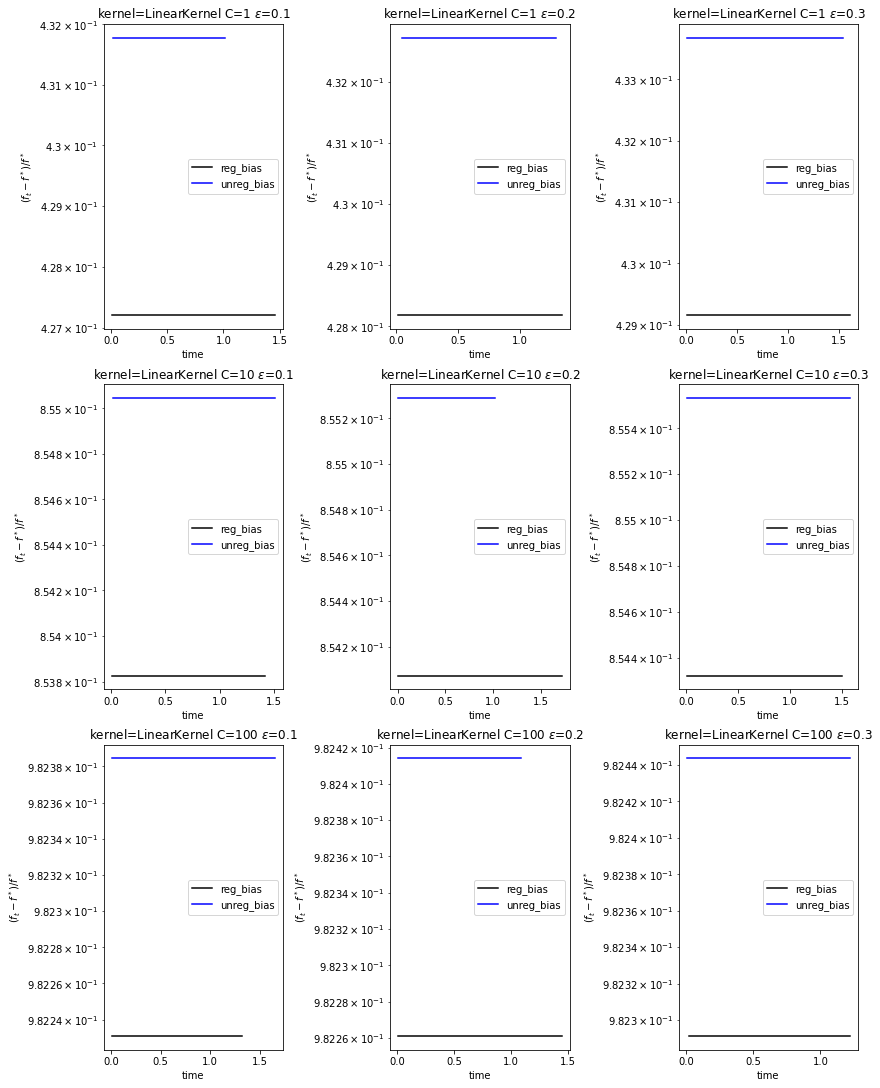

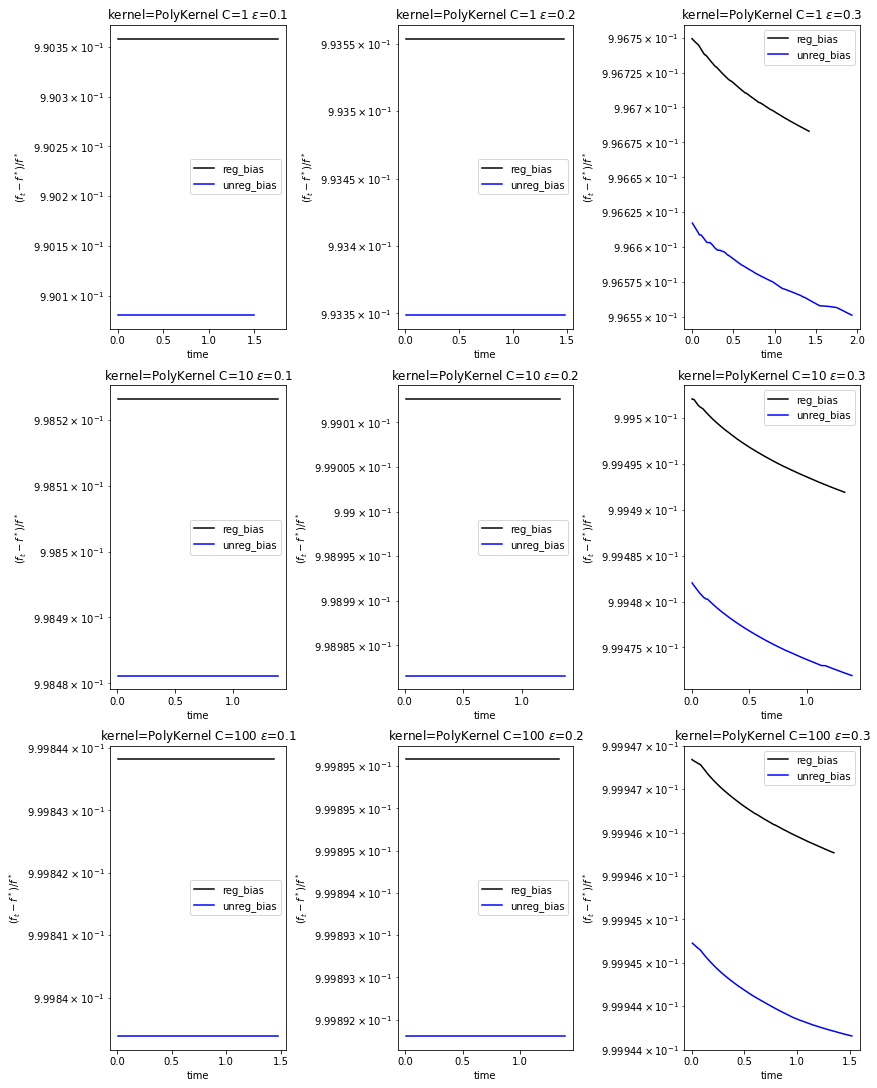

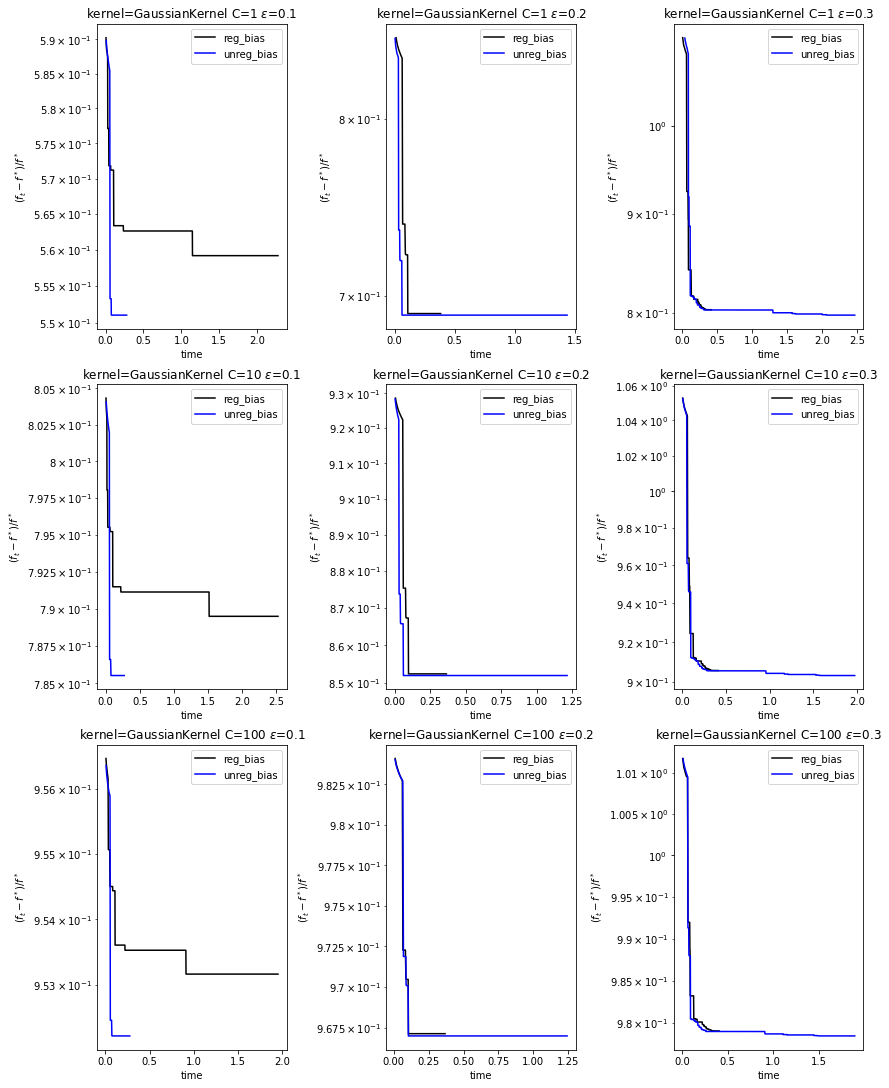

In [97]:
colors = {'reg_bias': 'k',
          'unreg_bias': 'b'}
linear_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
linear_ax = linear_fig.subplots(3, 3)
poly_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
poly_ax = poly_fig.subplots(3, 3)
gaussian_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
gaussian_ax = gaussian_fig.subplots(3, 3)
axes = {'LinearKernel': linear_ax,
        'PolyKernel': poly_ax,
        'GaussianKernel': gaussian_ax}
for dual, _dict1 in train_loss_history.items():
    for kernel, _dict2 in _dict1.items():
        for (C, _dict3), row_ax in zip(_dict2.items(), axes[kernel]):
            for (eps, history), loss in zip(_dict3.items(), row_ax):
                loss.plot(history[0], history[1], color=colors[dual])
                loss.set_title('kernel={} C={:d} $\epsilon$={:.1f}'.format(kernel, C, eps))
                loss.set_xlabel('time')
                loss.set_ylabel('$(f_t - f^*) / f^*$')
                loss.set_yscale('log')
                loss.legend(colors.keys()).get_frame().set_facecolor('white')
linear_fig.savefig('./tex/img/linear_lagrangian_dual_l1_svr_loss_history.png')
poly_fig.savefig('./tex/img/poly_lagrangian_dual_l1_svr_loss_history.png')
gaussian_fig.savefig('./tex/img/gaussian_lagrangian_dual_l1_svr_loss_history.png')

## Squared Epsilon-insensitive loss

### Primal formulation

In [60]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [61]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def primal_r2_scorer(svr, X, y):
    if hasattr(svr, 'train_loss_history'):
        
        from optiml.ml.svm import DualSVR
        from optiml.ml.svm.kernels import LinearKernel
        
        dual_svr = DualSVR(loss=squared_epsilon_insensitive, 
                           kernel=LinearKernel(), 
                           C=svr.C, 
                           reg_intercept=True, 
                           optimizer='cvxopt').fit(lin_X, lin_y)
        f_star = np.full_like(svr.train_loss_history, svr.loss(np.append(dual_svr.coef_, dual_svr.intercept_)))
        # (f_t - f^*) / f^*
        train_loss_history[svr.momentum_type][svr.C][svr.epsilon] = np.divide((svr.train_loss_history - f_star), 
                                                                              np.maximum(abs(f_star), 1))
        
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.iter, 
            'n_sv': len(svr.support_)}

Fitting 1 folds for each of 9 candidates, totalling 9 fits
     pcost       dcost       gap    pres   dres
 0: -1.1466e+04 -3.4431e+03  6e+04  3e+02  3e-01
 1: -5.5985e+03 -1.4064e+04  8e+03  5e-14  3e-15
 2: -9.9336e+03 -1.0665e+04  7e+02  4e-14  3e-15
 3: -1.0317e+04 -1.0367e+04  5e+01  3e-14  2e-15
 4: -1.0342e+04 -1.0344e+04  2e+00  4e-14  2e-15
 5: -1.0343e+04 -1.0343e+04  7e-02  3e-14  2e-15
 6: -1.0343e+04 -1.0343e+04  1e-03  3e-14  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1466e+04 -3.4431e+03  6e+04  3e+02  3e-01
 1: -5.5985e+03 -1.4064e+04  8e+03  5e-14  3e-15
 2: -9.9336e+03 -1.0665e+04  7e+02  4e-14  3e-15
 3: -1.0317e+04 -1.0367e+04  5e+01  3e-14  2e-15
 4: -1.0342e+04 -1.0344e+04  2e+00  4e-14  2e-15
 5: -1.0343e+04 -1.0343e+04  7e-02  3e-14  2e-15
 6: -1.0343e+04 -1.0343e+04  1e-03  3e-14  2e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.1466e+04 -3.4431e+03  6e+04  3e+02  3e-01
 1: -5.5985e+0

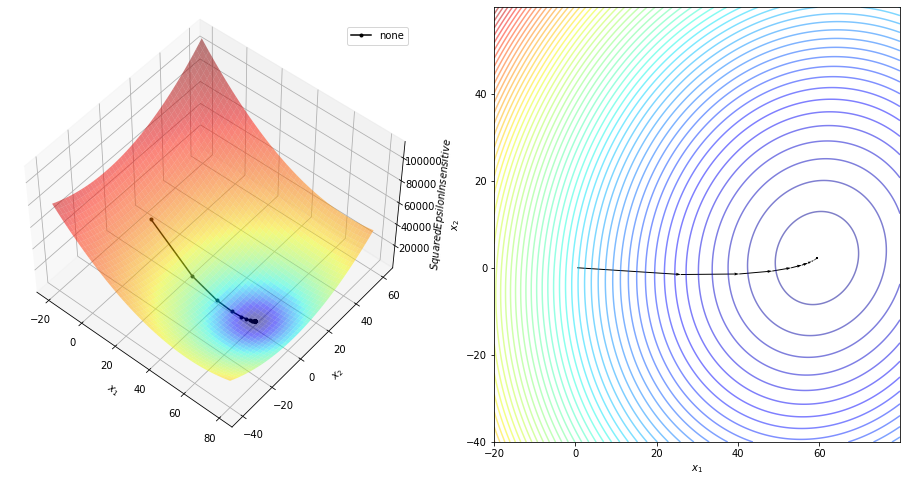

In [65]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='none', 
                              early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss, grid.best_estimator_.optimizer, 
                                                    color='k', label='none')

In [66]:
none_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
none_primal_svr_squared_eps_cv_results.insert(1, 'momentum', 'none')
none_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_svr_squared_eps_cv_results

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='standard', 
                              momentum=0.4, 
                              early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='b', label='standard')
squared_eps_loss_opt

In [ ]:
standard_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svr_squared_eps_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
standard_primal_svr_squared_eps_cv_results

In [ ]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, 
                              optimizer=StochasticGradientDescent, 
                              learning_rate=0.02, 
                              momentum_type='nesterov', 
                              momentum=0.4, 
                              early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='r', label='nesterov')
squared_eps_loss_opt.savefig('./tex/img/l2_svr_loss.png')
squared_eps_loss_opt

In [ ]:
nesterov_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svr_squared_eps_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_svr_squared_eps_cv_results

In [ ]:
custom_primal_svr_squared_eps_cv_results = none_primal_svr_squared_eps_cv_results.append(
    standard_primal_svr_squared_eps_cv_results).append(
    nesterov_primal_svr_squared_eps_cv_results)
custom_primal_svr_squared_eps_cv_results

In [ ]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for momentum, _dict1 in train_loss_history.items():
    for (C, _dict2), row_ax in zip(_dict1.items(), axes):
        for (eps, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[momentum])
            loss.set_title('C={:d} $\epsilon$={:.1f}'.format(C, eps))
            loss.set_xlabel('iteration')
            loss.set_ylabel('$(f_t - f^*) / f^*$')
            loss.set_yscale('log')
            loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/l2_svr_loss_history.png')

In [50]:
grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive', 
                                random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [51]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.001270  0.977554      96   100
                       0.2      0.000935  0.977553      96   100
                       0.3      0.000953  0.977551      96   100
                   10  0.1      0.003284  0.977577     826   100
                       0.2      0.004081  0.977576     826    99
                       0.3      0.003131  0.977576     839    99
                   100 0.1      0.004197  0.977538    1000   100
                       0.2      0.004413  0.977540    1000    99
                       0.3      0.004074  0.977541    1000    98

In [52]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_l2_svr.tex', 
                                           caption='Primal $\protect \mathcal{L}_2$-SVR results', 
                                           label='primal_l2_svr_cv_results', position='H')
primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
sgd       none     1   0.1      0.615199  0.977019     652   100
                       0.2      0.695356  0.977008     655    99
                       0.3      0.666181  0.976996     657    99
                   10  0.1      0.144386  0.977572      75    99
                       0.2      0.148201  0.977572      75    99
                       0.3      0.147046  0.977571      76    99
                   100 0.1      0.025311  0.977413       8   100
                       0.2      0.032301  0.977418       9    99
                       0.3      0.038598  0.977423       9    98
          standard 1   0.1      0.374330  0.977028     405   100
                       0.2      0.435667  0.977018     407    99
                       0.3      0.446224  0.977006     408    99
                   10  0.1      0.093759  0.977572      42    99
                       0.2      0.114295  0.977571      42    99
                       0.3      0.116853  0.977571      43    99
                   100 0.1      0.016488  0.977443       6    99
                       0.2      0.021925  0.977447       6    99
                       0.3      0.023651  0.977450       6    97
          nesterov 1   0.1      0.383592  0.977028     406   100
                       0.2      0.449226  0.977018     408    99
                       0.3      0.442081  0.977006     409    99
                   10  0.1      0.110401  0.977572      43    99
                       0.2      0.118366  0.977571      43    99
                       0.3      0.111995  0.977570      43    99
                   100 0.1      0.032469  0.977417       6   100
                       0.2      0.027207  0.977423       6    99
                       0.3      0.034640  0.977428       6    98
liblinear -        1   0.1      0.001270  0.977554      96   100
                       0.2      0.000935  0.977553      96   100
                       0.3      0.000953  0.977551      96   100
                   10  0.1      0.003284  0.977577     826   100
                       0.2      0.004081  0.977576     826    99
                       0.3      0.003131  0.977576     839    99
                   100 0.1      0.004197  0.977538    1000   100
                       0.2      0.004413  0.977540    1000    99
                       0.3      0.004074  0.977541    1000    98